### EDA Plan:
1. Clean districts_info.csv such that data can be interpreted easily
2. Merge engagement data for all districts
3. EDA on district and engagement data to see general trends, possibilities of correlations
4. Merging dataset into pandas, remmoving redundant rows/columns
5. Switching to a sqlite database if needed

In [1]:
# Importing the required libraries
import pandas as pd
import glob
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Merging engagement data for all districts
# First we will read all the files in the directory
path = os.getcwd()
parent_dir = os.path.dirname(path)
data_dir = os.path.join(parent_dir, 'data')
data_files_path = os.path.join(data_dir, 'engagement_data')
print(data_files_path)

/Users/eshan23/eshanprashar_git_profile/kaggle_practice/L1_education/covid_edtech_usage/data/engagement_data


In [4]:
# Use glob to read all the files in the directory
# glob() is used in system libraries. In Python, the glob module is used to retrieve files/pathnames matching a specified pattern. 
# The pattern rules of glob follow standard Unix path expansion rules. It is also predicted that according to benchmarks it is faster
# than other methods to match pathnames in directories. With glob, we can also use wildcards ("*, ?, [ranges])

# Use glob to create list of all files
def get_all_files(data_files_path):
    extracted_files = []
    source_files = glob.glob(data_files_path + "/*.csv")
    for file in source_files:
        filename = file.split('/')[-1]
        district_id = int(filename.replace('.csv',''))
        df = pd.read_csv(file)
        df['district_id'] = district_id
        extracted_files.append(df)
        print(f'Added {len(df)} rows from {filename}')
    combined_df = pd.concat(extracted_files, ignore_index=True)
    print(f'Combined {len(combined_df)} rows from {len(extracted_files)} files')
    return combined_df

In [10]:
# Get the engagement data and examine the first few rows
engagement_data = get_all_files(data_files_path)
print(engagement_data.head())

Added 67430 rows from 3188.csv
Added 48038 rows from 7305.csv
Added 57118 rows from 7675.csv
Added 34909 rows from 1204.csv
Added 31151 rows from 4591.csv
Added 96960 rows from 6345.csv
Added 46718 rows from 4744.csv
Added 48639 rows from 2321.csv
Added 122615 rows from 3228.csv
Added 38439 rows from 8433.csv
Added 86706 rows from 3412.csv
Added 36263 rows from 7660.csv
Added 82852 rows from 6998.csv
Added 246725 rows from 8784.csv
Added 162329 rows from 3160.csv
Added 38790 rows from 1039.csv
Added 169386 rows from 9303.csv
Added 67800 rows from 5934.csv
Added 120909 rows from 1549.csv
Added 110132 rows from 2685.csv
Added 85847 rows from 8425.csv
Added 30531 rows from 3558.csv
Added 85335 rows from 3772.csv
Added 81558 rows from 6144.csv
Added 134926 rows from 8815.csv
Added 55071 rows from 4949.csv
Added 61707 rows from 5882.csv
Added 88752 rows from 4550.csv
Added 46406 rows from 2257.csv
Added 202144 rows from 5510.csv
Added 83965 rows from 4183.csv
Added 104003 rows from 1000.csv

In [13]:
# Engagement data has 22M rows, which is too big
# Save the engagement data to a parquet file
engagement_data.to_parquet(os.path.join(data_dir, 'engagement_data.parquet'))

We now have a dataset with 22M rows with the following columns: {district_id, product_id, date, pct_access, engagement_index}. We can answer the following:
**Overall:**
1. Correlation of pct_access and engagement_index - Are there products where the engagement_index (page loads per 1000 students) are high even if the access is low?
    *   Pre-processing to ensure engagement_index is zero when pct_access is zero
    *   Products with highest pct_access
    *   Products with highest_engagement_index
2. Date: When do we see high and low engagement_index?
    *   Split into months, weekdays, weekends. 
    *   If possible, include holidays
3. Products: What product categories see the highest average engagement index?
4. Districts: 
    *   What is the average engagement index?
    *   Which districts are below average, which are above average?

In [14]:
# Now working with engagement dataframe. 
# First, we replace all NaN values in "engagement_index" with zeros
engagement_data['engagement_index'] = engagement_data['engagement_index'].fillna(0)

In [15]:
# Now, let's examine unique values in the district_id and lp_id columns
print(f'Total rows in engagement data: {len(engagement_data)}, total districts are {len(engagement_data.district_id.unique())}, total learning products are {len(engagement_data.lp_id.unique())}')

Total rows in engagement data: 22324190, total districts are 233, total learning products are 8647


There are 372 products in the products_info.csv while 8,647 in engagement data. Let's see how many rows correspond  to those 372 product ids.

In [19]:
# Extract product ids from product_info csv
product_info_csv = 'products_info.csv'
product_info = pd.read_csv(os.path.join(data_dir, product_info_csv))
product_ids = product_info['LP ID'].unique()
len(product_ids)


372

In [47]:
# Now filter the engagement_data and count number of rows with product ids in product_info
engagement_data_filtered = engagement_data[engagement_data['lp_id'].isin(product_ids)]
# Getting rid of all zeroes
engagement_data_filtered['lp_id'] = engagement_data_filtered['lp_id'].astype(int)

# We should also see if any districts are excluded
print(f'Filtered rows in engagement data: {len(engagement_data_filtered)}, total districts are {len(engagement_data_filtered.district_id.unique())}, total learning products are {len(engagement_data_filtered.lp_id.unique())}')

Filtered rows in engagement data: 11691587, total districts are 233, total learning products are 369


/var/folders/54/mhs5zkcs6zb1_y58hd7pczjc0000gn/T/ipykernel_74806/2396033464.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engagement_data_filtered['lp_id'] = engagement_data_filtered['lp_id'].astype(int)


All districts seem to have representation, so we will continue our analysis with the filtered dataset where:
* All products have associated categories in product_info dataframe
* engagement_index is zero when access is zero

In [48]:
# Saving the filtered engagement data to a parquet file
engagement_data_filtered.to_parquet(os.path.join(data_dir, 'engagement_data_filtered.parquet'))

In [5]:
# Read in the engagement_filtered parquet file
engagement_data_filtered = pd.read_parquet(os.path.join(data_dir, 'engagement_data_filtered.parquet'))
engagement_data_filtered.head()

,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,29322,0.04,1.30,3188
1,2020-01-01,57084,0.04,0.43,3188
2,2020-01-01,99916,0.09,5.20,3188
3,2020-01-01,58235,0.00,0.00,3188
4,2020-01-01,11585,0.04,1.30,3188


In [6]:
# Add a binary column called covid, which will be zero (pre-covid) from 2020-01-01 to 2020-03-15 and 1 (during covid)from 2020-03-16 onwards
engagement_data_filtered['time'] = pd.to_datetime(engagement_data_filtered['time'])
engagement_data_filtered['covid'] = (engagement_data_filtered['time'] >= '2020-03-16').astype(int)

# We should also add day of thr week and a binary variable for weekday (1 when weekday, 0 when weekend)
engagement_data_filtered['day_of_week'] = engagement_data_filtered['time'].dt.dayofweek
engagement_data_filtered['weekday'] = (engagement_data_filtered['day_of_week'] < 5).astype(int)
engagement_data_filtered['month'] = engagement_data_filtered['time'].dt.month
engagement_data_filtered['day'] = engagement_data_filtered['time'].dt.day
engagement_data_filtered.head(5)

,time,lp_id,pct_access,engagement_index,district_id,covid,day_of_week,weekday,month,day
0,2020-01-01,29322,0.04,1.30,3188,0,2,1,1,1
1,2020-01-01,57084,0.04,0.43,3188,0,2,1,1,1
2,2020-01-01,99916,0.09,5.20,3188,0,2,1,1,1
3,2020-01-01,58235,0.00,0.00,3188,0,2,1,1,1
4,2020-01-01,11585,0.04,1.30,3188,0,2,1,1,1


In [12]:
# Now let's plot the average pct_access and engagement_index over months
# Group by month and calculate the average pct_access and engagement_index
monthly_access = engagement_data_filtered.groupby('month')['pct_access'].mean().reset_index()
monthly_engagement = engagement_data_filtered.groupby('month')['engagement_index'].mean().reset_index()

# Examine data 
monthly_engagement.head(5)

,month,engagement_index
0,1,125.440396
1,2,194.255408
2,3,231.265214
3,4,245.087004
4,5,188.415083


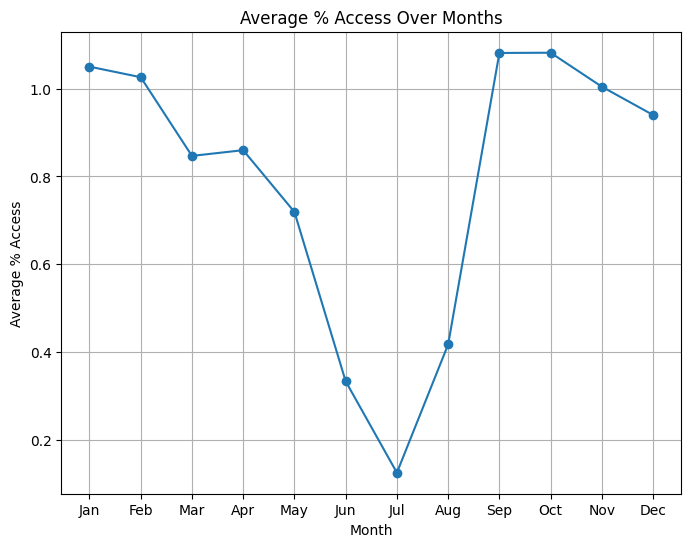

In [16]:
# Plotting average pct_access
plt.close()
plt.figure(figsize=(8, 6))
plt.plot(monthly_access['month'], monthly_access['pct_access'], marker='o')
plt.title('Average % Access Over Months')
plt.xlabel('Month')
plt.ylabel('Average % Access')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

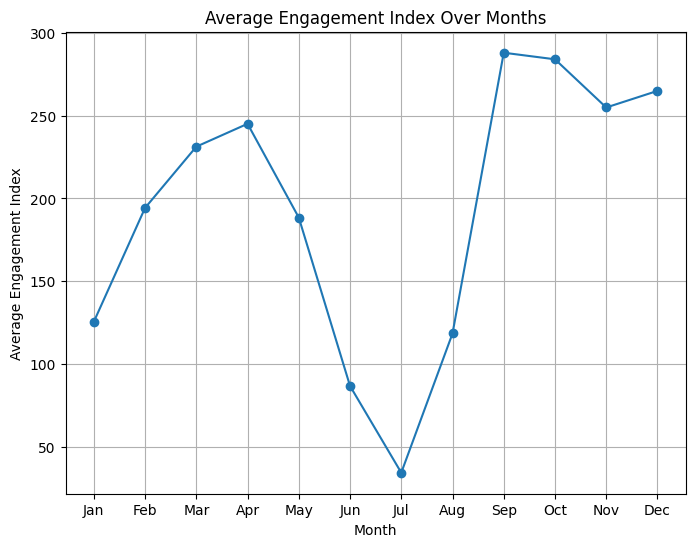

In [15]:
# Plotting engagement_index over months
plt.close()
plt.figure(figsize=(8, 6))
plt.plot(monthly_engagement['month'], monthly_engagement['engagement_index'], marker='o')
plt.title('Average Engagement Index Over Months')
plt.xlabel('Month')
plt.ylabel('Average Engagement Index')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [49]:
# Now let's analyse access and engagement index across products. For this, we can plot 2 histograms
# Calculate average pct_access and engagement_index for each product_id

group_by_column = 'lp_id'
avg_pct_access = engagement_data_filtered.groupby(group_by_column)['pct_access'].mean().reset_index()
avg_engagement_index = engagement_data_filtered.groupby(group_by_column)['engagement_index'].mean().reset_index()

# Sort in descending order
avg_pct_access = avg_pct_access.sort_values(by='pct_access', ascending=False)
avg_engagement_index = avg_engagement_index.sort_values(by='engagement_index', ascending=False)

# Examine one of the series
print(avg_pct_access.head())

     lp_id  pct_access
99   32213   16.202754
349  95731   15.395117
211  61292    8.235046
368  99916    8.194793
279  78063    7.650736


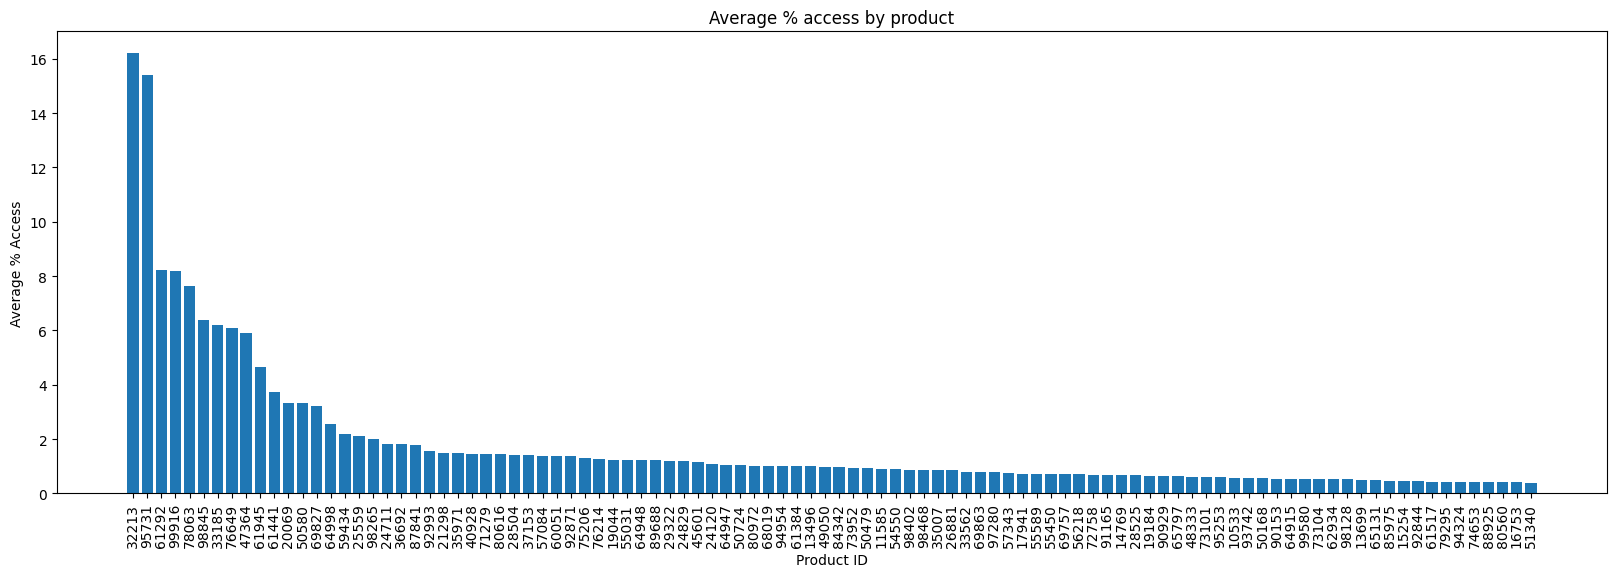

In [52]:
# Plotting the histograms
# Filtering top x values
values_to_plot = 100
top_avg_pct_access = avg_pct_access.head(values_to_plot)
top_avg_engagement_index = avg_engagement_index.head(values_to_plot)

# Creating the access plot
plt.close()
plt.figure(figsize=(20,6))
plt.bar(top_avg_pct_access[group_by_column].astype(str), top_avg_pct_access['pct_access'])
plt.title('Average % access by product')
plt.xlabel('Product ID')
plt.ylabel('Average % Access')
plt.xticks(rotation=90)
plt.show()

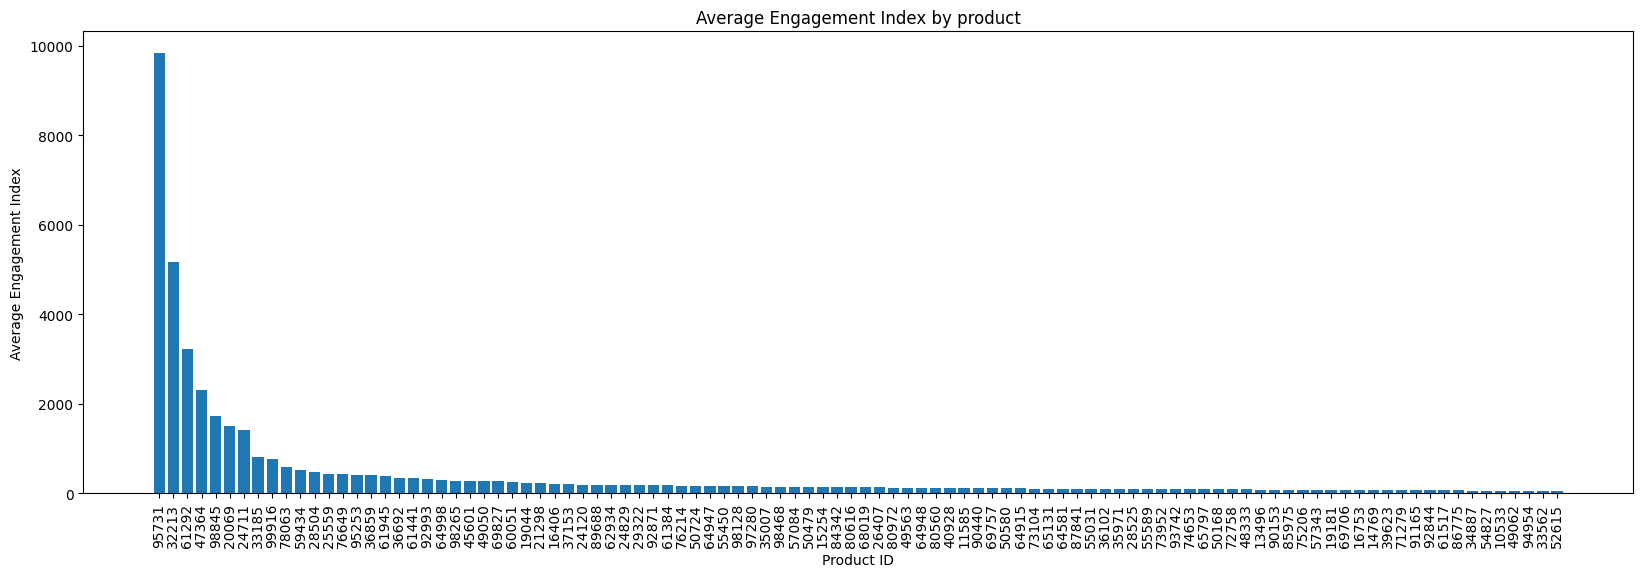

In [53]:
# Creating the engagement plot
plt.close()
plt.figure(figsize=(20,6))
plt.bar(top_avg_engagement_index[group_by_column].astype(str), top_avg_engagement_index['engagement_index'])
plt.title('Average Engagement Index by product')
plt.xlabel('Product ID')
plt.ylabel('Average Engagement Index')
plt.xticks(rotation=90)
plt.show()